# Importing all dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
from graphviz import Source
import os

# Preview of data

In [2]:
testing_data = pd.read_csv('cookie_cats.csv')
testing_data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# Number of gamerounds played by users accross different gate versions

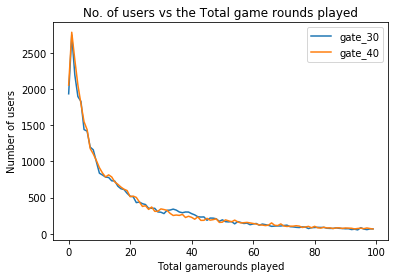

In [3]:
version_30 = testing_data.loc[testing_data['version'] == 'gate_30'].groupby(['sum_gamerounds']).agg({'userid':'count'}).reset_index()
version_40 = testing_data.loc[testing_data['version'] == 'gate_40'].groupby(['sum_gamerounds']).agg({'userid':'count'}).reset_index()
plt.plot(version_30['sum_gamerounds'].head(100), version_30['userid'].head(100), label = 'gate_30')
plt.plot(version_40['sum_gamerounds'].head(100), version_40['userid'].head(100), label = 'gate_40')
plt.xlabel('Total gamerounds played')
plt.ylabel('Number of users')
plt.title('No. of users vs the Total game rounds played')
plt.legend()

# Visualizing retention after 1 week and 7 weeks for all gate versions
In this case, the metric is user retention which is represented in the columns retention_1 and retention_7

In [107]:
df = testing_data
gate_30_counts = df.loc[df['version'] == 'gate_30']
gate_40_counts = df.loc[df['version'] == 'gate_40']

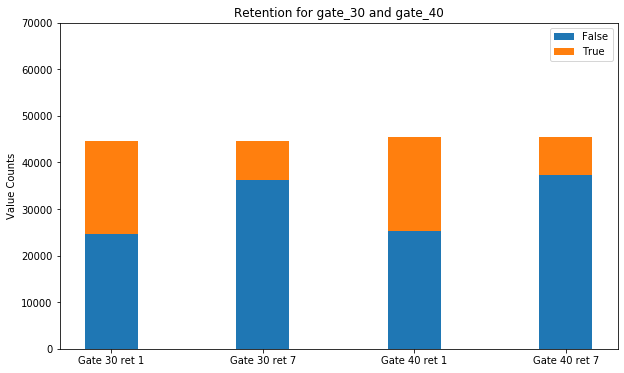

In [108]:
N = 4
# when players dont return to play the game 1 and 7 days after installing the versions gate_30 and gate_40
#the following values count the number of True and False values for each gate type
gate_30_40_0 = [gate_30_counts['retention_1'].value_counts()[0], gate_30_counts['retention_7'].value_counts()[0], 
                        gate_40_counts['retention_1'].value_counts()[0], gate_40_counts['retention_7'].value_counts()[0]]
# when players return to play the game 1 and 7 days after installing the version
gate_30_40_1 = [gate_30_counts['retention_1'].value_counts()[1], gate_30_counts['retention_7'].value_counts()[1], 
                        gate_40_counts['retention_1'].value_counts()[1], gate_40_counts['retention_7'].value_counts()[1]]

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(10, 6))
p1 = plt.bar(ind, gate_30_40_0, width)
p2 = plt.bar(ind, gate_30_40_1, width, bottom=gate_30_40_0)

plt.ylabel('Value Counts')
plt.title('Retention for gate_30 and gate_40')
plt.xticks(ind, ('Gate 30 ret 1', 'Gate 30 ret 7', 'Gate 40 ret 1', 'Gate 40 ret 7'))
plt.yticks(np.arange(0, 75000, 10000))
plt.legend(('False', 'True'))

plt.show()

The above plot shows that visually, the distribution of retention outcomes for gate_30 and gate_40 are somewhat similar. But we should perform a ttest to understand which group is doing better even if marginally

# ttest

In [109]:
#a simple t-test here should work. We have collected ~0.5MM data and test/control split is ~50/50.
from scipy import stats
  
#t-test of test vs control for our target metric 
test = stats.ttest_ind(df[df['version'] == 'gate_30']['retention_1'], 
                       df[df['version'] == 'gate_40']['retention_1'], 
                       equal_var=False
                       )
  
print(df.groupby('version')['retention_1'].mean())
a = df.groupby('version')['retention_1'].mean()[0]
b = df.groupby('version')['retention_1'].mean()[1]
print( (a - b)/a * 100)

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64
1.317565585974659


The gate_40 version performs worse than gate_30 for retention rate after week 1 by approximately 1.3%

# Retention after 7 weeks

In [110]:
#t-test of test vs control for our target metric 
test = stats.ttest_ind(df[df['version'] == 'gate_30']['retention_7'], 
                       df[df['version'] == 'gate_40']['retention_7'], 
                       equal_var=False
                       )
  
print(df.groupby('version')['retention_7'].mean())
a = df.groupby('version')['retention_7'].mean()[0]
b = df.groupby('version')['retention_7'].mean()[1]
print( (a - b)/a * 100)


version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64
4.311903489646016


The gate_40 version performs worse than gate_30 for retention rate after 7 weeks by approximately 4.3%

We can conclude that the gate_40 version performs worse than gate_30 for both after 1 week and 7 weeks.

# Sampling distributions for 1-week retentions

In [48]:
df_1d = []
df_7d = []
for i in range(100):
    df_1d.append(100 * testing_data.sample(replace = True, frac = 1)
                 .groupby(['version'])['retention_1'].mean())
    df_7d.append(100 * testing_data.sample(replace = True, frac = 1)
                 .groupby(['version'])['retention_7'].mean())
df_1d = pd.DataFrame(df_1d)
df_7d = pd.DataFrame(df_7d)
df_1d['diff'] = df_1d['gate_30'] - df_1d['gate_40']
df_7d['diff'] = df_7d['gate_30'] - df_7d['gate_40']


# Sampling distribution for different versions for retention_1 

Index(['gate_30', 'gate_40', 'diff'], dtype='object', name='version')

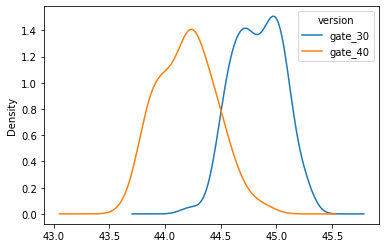

In [57]:
df_1d[['gate_30', 'gate_40']].plot(kind = 'kde')
df_1d.columns

# Difference in mean for version 30 and 40 for 1 week retention

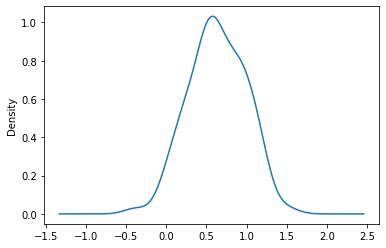

In [50]:
df_1d['diff'].plot(kind = 'kde')

# Sampling distributions for 7-week retentions

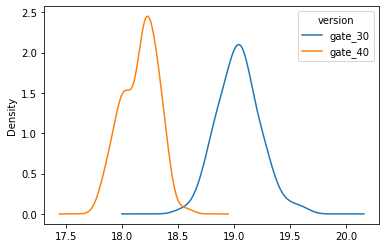

In [51]:
df_7d[['gate_30', 'gate_40']].plot(kind = 'kde')

# Difference in mean for version 30 and 40 for 1 week retention

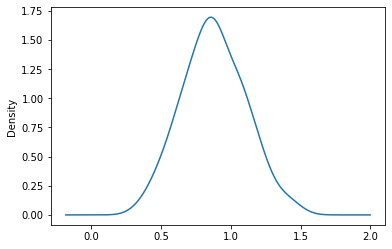

In [52]:
df_7d['diff'].plot(kind = 'kde')

# Probability of seeing a difference in retention rates for gate_30 and gate_40

In [59]:
print('1 week retention')
print((df_1d['diff']>0).sum()/ len(df_1d)*100)
print(' 7 week retention')
print((df_7d['diff']>0).sum()/ len(df_1d)*100)

1 week retention
96.0
 7 week retention
100.0


There is definitely a drop in retention rates when the version the players played is gate_40 and this difference in most likely not due to chance. It's especially significant for 7 week retentions. Therefore, it is better to use gate_30 if the app is optimizing for user retention rates